# SSP2024: Homework 1 Notebook.

# Overview

In this homework we will use [Librosa](https://librosa.org/doc/latest/index.html) and [pysptk](http://sp-tk.sourceforge.net/). Both of these libraries have implementations of speech analysis and signal processing algorithms along with helper functions for data loading and visualization. You can find more documentation about each of these online ([Librosa docs](https://librosa.org/doc/latest/index.html), [pysptk github](https://github.com/r9y9/pysptk)).


**Deadline: 2024.11.12 24:00**

You have 3 days late policy. Any submissions within three days of the deadline can still be accepted but with penalty. Submission after three days of the deadline will not be accepted and marked as zero. This homework have two parts totally.




---

# PART 1

This part will introduce you to the processing procedures for the audio data. There are a total of 10 problems in this part. The tasks in this part make up 50 points of the overall 110 for Homework 1. First, you need to install and import the necessary libraries. 


In [1]:
!pip install "librosa~=0.10.1" "matplotlib~=3.7.1" pysptk

In [2]:
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import matplotlib.pyplot as plt

# used to play audio files
import IPython.display as ipd
from base64 import b64decode

## I. Data preparation

 In this homework, we will take our first glance at a handful of raw audio clips between bank employees and customers from the [HarperValleyBank dataset](https://arxiv.org/abs/2010.13929). Working with audio files in this way is similar to what you might experience when working with data exported from call center recordings or similar telephone/app-based human-human interactions. To start, ensure you can execute the commands below to locate and load the audio files.

In [3]:
# download dataset from public GDrive
!wget -O hvb_sampledata.zip https://drive.usercontent.google.com/download?id=1tFaTu7LWuCxn3DkAyudGGyv6eilVO5pC
# https://drive.google.com/file/d/1tFaTu7LWuCxn3DkAyudGGyv6eilVO5pC

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [4]:
!ls
!unzip -o hvb_sampledata.zip

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
'unzip' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [5]:
ls sample

 ������ D �еľ��� Data
 �������к��� 4CA1-2F42

 d:\Repositories\course\SSP2024\ssp2024_HW1\HW1-v3\sample ��Ŀ¼

2022/03/26  13:04    <DIR>          .
2024/11/04  13:56    <DIR>          ..
2022/03/27  04:04             6,148 .DS_Store
2021/01/13  01:37    <DIR>          agent
2021/01/13  01:37    <DIR>          caller
               1 ���ļ�          6,148 �ֽ�
               4 ��Ŀ¼ 439,080,665,088 �����ֽ�


In the `sample` folder, we've put a few example conversations between an agent (bank employee) and a caller (bank customer). Each conversation is split into two `.wav` files by speaker. For example, `sample/agent/0002f70f7386445b.wav` and `sample/caller/0002f70f7386445b.wav` belong to the same conversation. The first file contains everything the agent says while the second contains everything the caller says. This speaker-separated format is common in speech corpora.

In [6]:
ls sample/agent

������ʽ����ȷ - "gent"��


In [7]:
ls sample/caller

������ʽ����ȷ - "caller"��


## II. Playing audio files & Loading into an array

We can listen to the audio files to familiarize ourselves with the data. The long pauses you hear between utterances is because each audio file is from only one side of the conversation.

In [8]:
# agent side of the conversation
ipd.Audio("./sample/agent/0002f70f7386445b.wav", rate=22050)

In [9]:
# caller side of the conversation
ipd.Audio("./sample/caller/0002f70f7386445b.wav", rate=22050)

When working with spoken language, we often want to visualize and process the raw audio before applying machine learning or signal processing approaches. To do this, we typically work with an audio file as an array or tensor. Our audio files are a single channel (mono, not stereo), or we sometimes have a two-party conversation encoded as stereo with one speaker in the left/right channel for separation.

The `librosa` package contains a suite of utilities to open and process waveforms. The function `librosa.load` loads an audio file as a floating point time series. It will return a numpy array containing samples from the audio clip and the sample rate (`sr`) listed in the audio file header. The sample rate is an integeter for how many samples (array indices) correspond to 1 second of realtime audio. The higher the sample rate, the higher the "resolution" of an audio clip.

In [10]:
# sr represents a "sample rate"
wav_agent, sr_agent = librosa.load("./sample/agent/0002f70f7386445b.wav")
wav_caller, sr_caller = librosa.load("./sample/caller/0002f70f7386445b.wav")

Like above, there are long pauses in each clip where the other speaker is speaking.  These "silence" gaps are intended to allow users to recover the original conversation if needed.

### **Problem 1 (8 points): Combine both conversation sides into a single array** 

To familiarize yourself with waveforms and `librosa`, merge the agent and caller waveforms into a single waveform. You may assume that the audio files to combine will always have the same sampling rate `(sr_caller == sr_agent)`. If two files are unequal length, your combined audio should be length = max( length_1, length_2), using 0 padding when necessary.

In [11]:
merged_wav = None  # TODO: define this variable
sr_merged = sr_agent

#############################
#### YOUR CODE GOES HERE ####
max_length = max(len(wav_agent), len(wav_caller))
merged_wav = np.zeros(max_length)
merged_wav[: len(wav_agent)] = wav_agent
merged_wav[: len(wav_caller)] = np.maximum(merged_wav[: len(wav_caller)], wav_caller)

#############################

Use `ipd.Audio` to play the merged waveform. It should sound like a 2-person conversation now!

In [12]:
ipd.Audio(merged_wav, rate=sr_merged)

## III. Visualizing audio using time-frequency spectrograms

In general, it is hard to directly work with waveforms in machine learning. There are differences in magnitude, variable lengths, and speech-relevant patterns are hard to discern by visualizing a waveform directly. We often rely on signal processing tools to "standardize" waveforms. In speech, it is common to convert raw waveforms to the frequency domain with _spectrograms_. A spectrogram is a time series of short-window fourier transforms, so we can see how the frequencies of speech change over the course of an utterance.

The human auditory system does not perceive all frequencies equally. In very low or high frequencies (in hertz), our ears are less capable at discriminating between different frequencies.

The Mel-scale is a scale of pitches judged by human listeners to be equal in distance one from another. It is roughly linear between 0 and 1000hz and logarithmic above 1000hz, as human ears become less adept at differentiating frequencies. We can think of Mel scale as a 'bin size' of frequencies to match how humans perceive speech. This is helpful when building spoken language systems because it means our feature representations more closely match what a human listener would perceive from the same audio. Here is a quick visualization of Mel scale:

C:\Users\LockOn\AppData\Local\Temp\ipykernel_21960\1872783322.py:2: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa.filters.mel(sr=sr_agent, n_fft=256, n_mels=128, fmax=fmax_dataset)


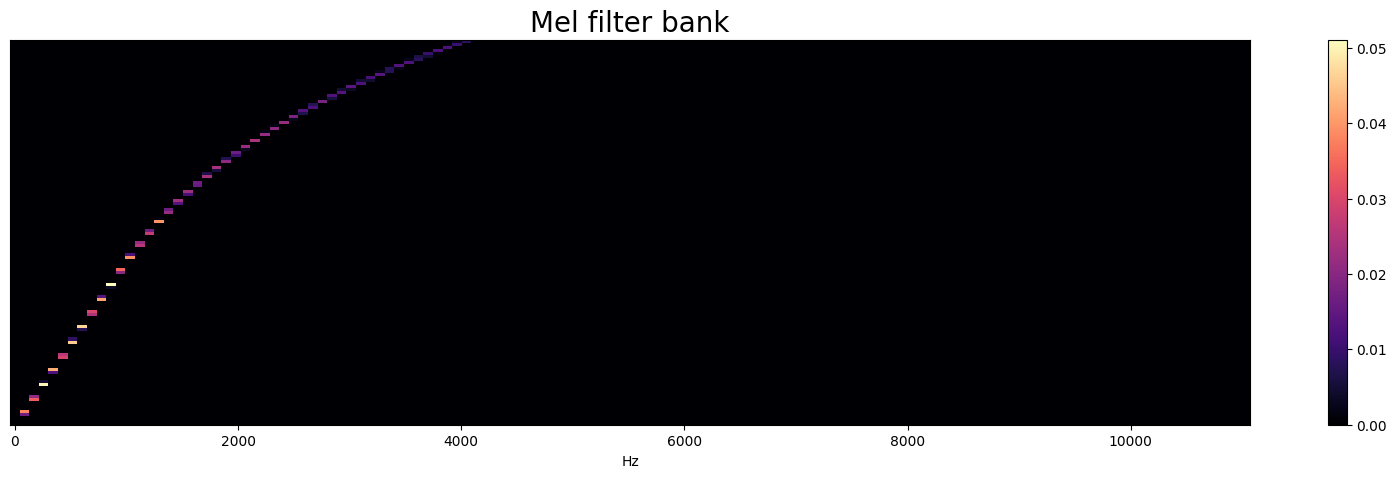

In [13]:
fmax_dataset = 4096
mel_basis = librosa.filters.mel(sr=sr_agent, n_fft=256, n_mels=128, fmax=fmax_dataset)

plt.figure(figsize=(20, 5))
librosa.display.specshow(mel_basis, x_axis="linear", fmax=fmax_dataset)
plt.title("Mel filter bank", fontsize=20)
plt.colorbar()
plt.show()

We will use this helper function to visualize your merged audio file. Note the keywords used below. First we will set the max frequency considered for our mel scale (`fmax`) to the max possible frequency for this sampling rate (Nyquist Frequency, `sample_rate/2`). The number of bins is effectively the "resolution" in mel scale of the vertical axis.

In [14]:
# helper function to plot a mel spectrogram
# arguments: (wave array, sampling rate, number of mel bins, max frequency of mel scale)
def plot_melspectrogram(
    wav, sr, annotations=None, n_mels=256, fmax=4096, fig=None, ax=None, show_legend=True
):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    M = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, fmax=fmax, n_fft=2048)
    M_db = librosa.power_to_db(M, ref=np.max)
    img = librosa.display.specshow(M_db, y_axis="mel", x_axis="time", ax=ax, fmax=fmax)
    if show_legend:
        ax.set(title="Mel spectrogram display")
        fig.colorbar(img, ax=ax, format="%+2.f dB")

    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x, y, text in annotations:
            ax.annotate(
                text,
                xy=(x, y),
                xycoords="data",
                xytext=(10, -50),
                textcoords="offset pixels",
                horizontalalignment="right",
                color="white",
                fontsize=20,
                verticalalignment="bottom",
                arrowprops=dict(arrowstyle="-|>", color="white", lw=1, ls="-"),
            )

Now we can use the helper function to visualize a Mel spectrogram of the combined audio file you created

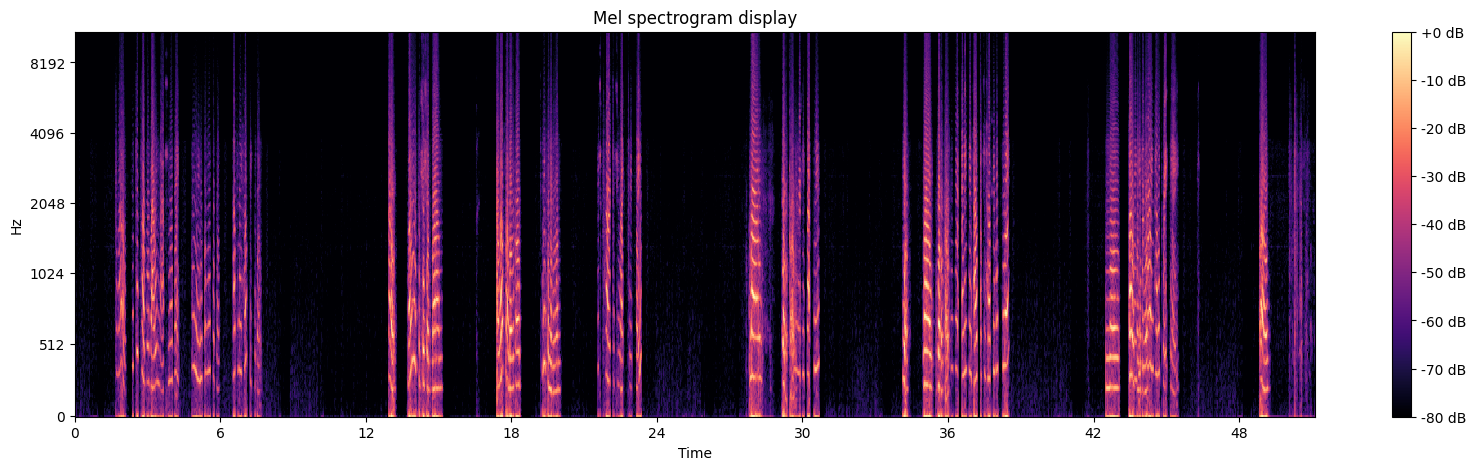

In [15]:
plot_melspectrogram(merged_wav, sr_agent, annotations=None, n_mels=256, fmax=sr_agent / 2)

Notice there is no energy above 4kHz. The dataset was collected using telephone speech, which has a sampling rate of 8kHz. Therefore the highest meaningful frequency in these recordings is 4kHz. Use the plotting arguments below as your default when displaying audio to hand in. For convenience we also set these as the default for the helper function.

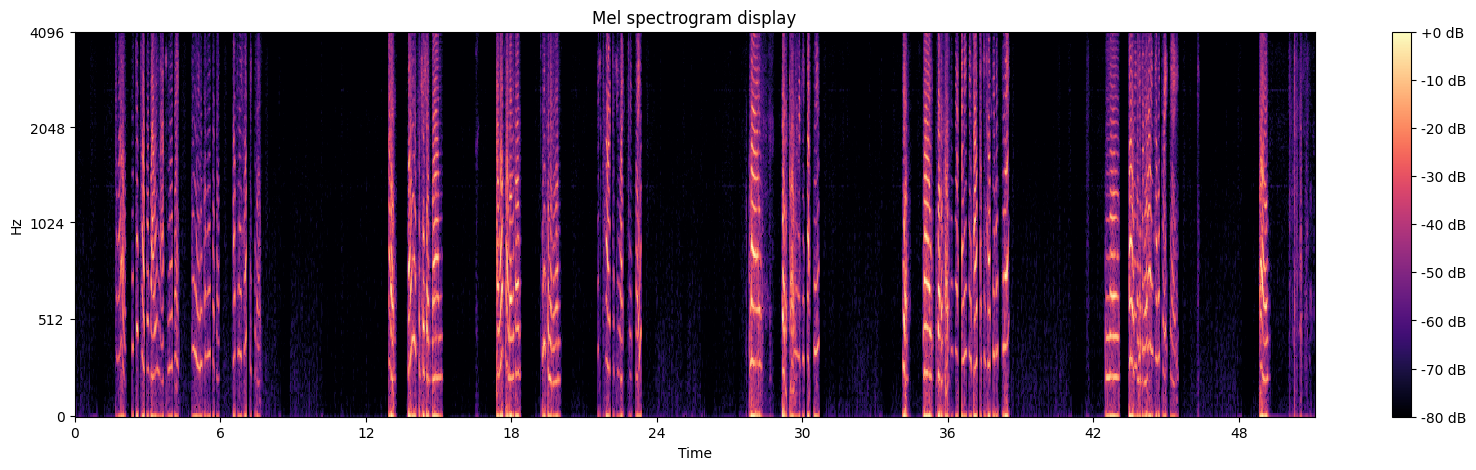

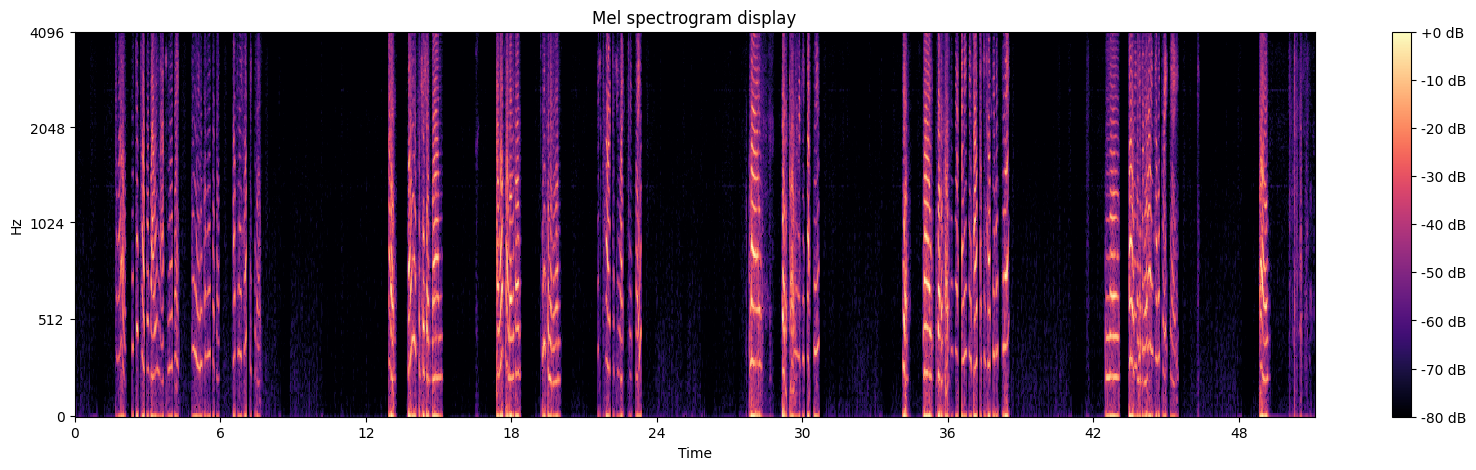

In [16]:
# we can adjust the keyword arguments
fmax_dataset = 4096
plot_melspectrogram(merged_wav, sr_agent, annotations=None, n_mels=256, fmax=fmax_dataset)
plot_melspectrogram(merged_wav, sr_agent)

### **Problem 2 (8 points): Silence removal** 

We often analyze utterances from a single speaker at a time, rather than the conversation. We also want to focus on the actual _speech_ audio rather than long silences / pauses between utterances.

Focusing on the **agent**, your task is to remove most of the major silences from the raw waveform file. This will collapse all of the agent's utterances into a single array with just short pauses between utterances. Removing silences in this way helps focus on the speech parts of an audio file. Sometimes this process is called _voice activity detection_ (and is more dificult in scenarios with strong background noise or distortion when speech can be hard to identify from the background).

One way to do this:

1. Use `librosa.effects.split` to split the agent .wav file by silence.
2. Clip out the silences and combine the audio back into a single array with silences removed. Ensure you aren't filtering too aggressively and clipping out actual audio.

You are free to try other approaches to silence removal. It should sound like a more or less continuous utterance stream from the speaker, but it need not be perfect. Describe your approach briefly along with the implementation.

In [17]:
recon_agent = None  # TODO: create a NumPy array with silences removed

#############################
#### YOUR CODE GOES HERE ####

# Split the agent's audio by silence(which is defined by top_db)
split_intervals = librosa.effects.split(wav_agent, top_db=60)

# Concat intervals that contain speech
recon_agent = np.concatenate([wav_agent[start:end] for start, end in split_intervals])

#############################

In [18]:
# listen to your audio file
ipd.Audio(recon_agent, rate=sr_agent)

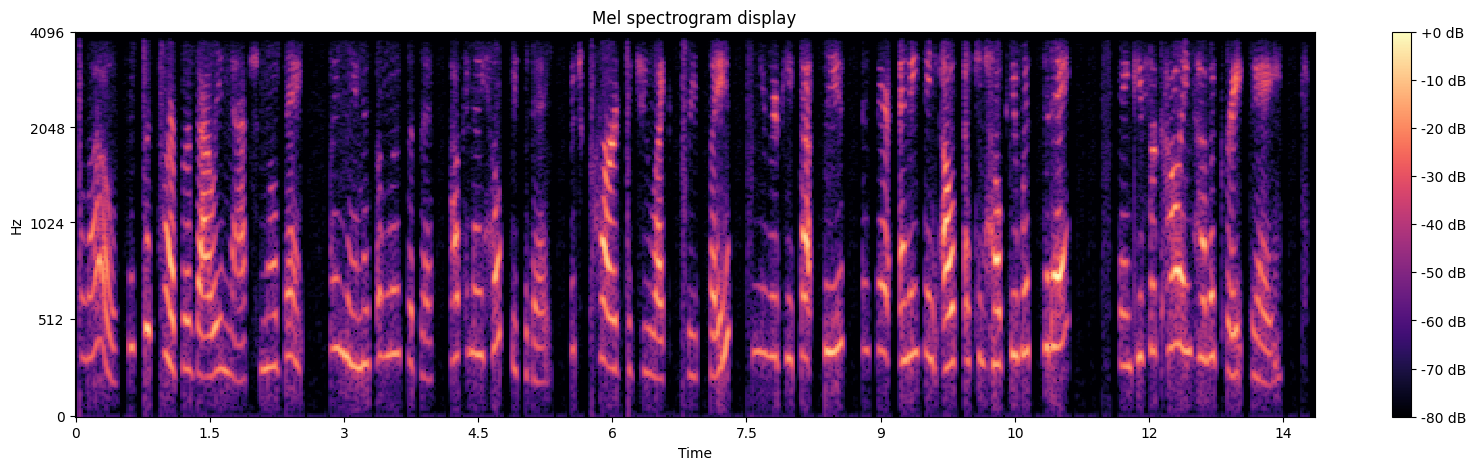

In [19]:
# This should now have minimal gaps between utterances
# (leaving some small silences is okay)
plot_melspectrogram(recon_agent, sr_agent)

### **Problem 3 (8 points): Segment a single utterance**

Finally, an entire audio signal is too long, so let's pick a few utterances for further work.

In the conversation above, the agent says the following: `This is Harper Valley National Bank. My name is Elizabeth. How can I help you today?`. Slice a single wave array for just this part of the utterance and visualize the corresponding spectrogram.

In [20]:
audio_signal = None  # TODO: represent as a NumPy array

#############################
#### YOUR CODE GOES HERE ####
audio_signal = recon_agent[9000:120000]
#############################

In [21]:
# listen to your audio file
ipd.Audio(audio_signal, rate=sr_agent)

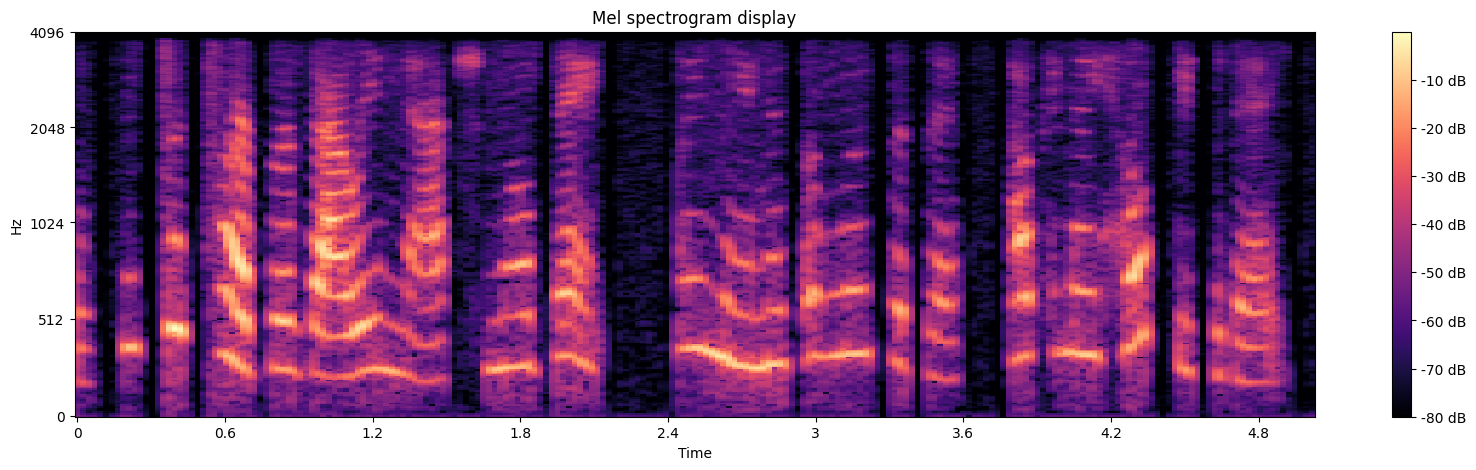

In [22]:
plot_melspectrogram(audio_signal, sr_agent)

### **Task 4 (10 points): Label words in the spectrogram** 

We know the true _transcript_ for this utterance, but it's also important to build an understanding of how words and phonemes appear in a spectrogram representation. This assists when debugging spoken language systems, and especially when building text to speech engines.

Using the helper function we created, you can add text labels to the spectrogram plot. Here is a single annotation to demonstrate the format:

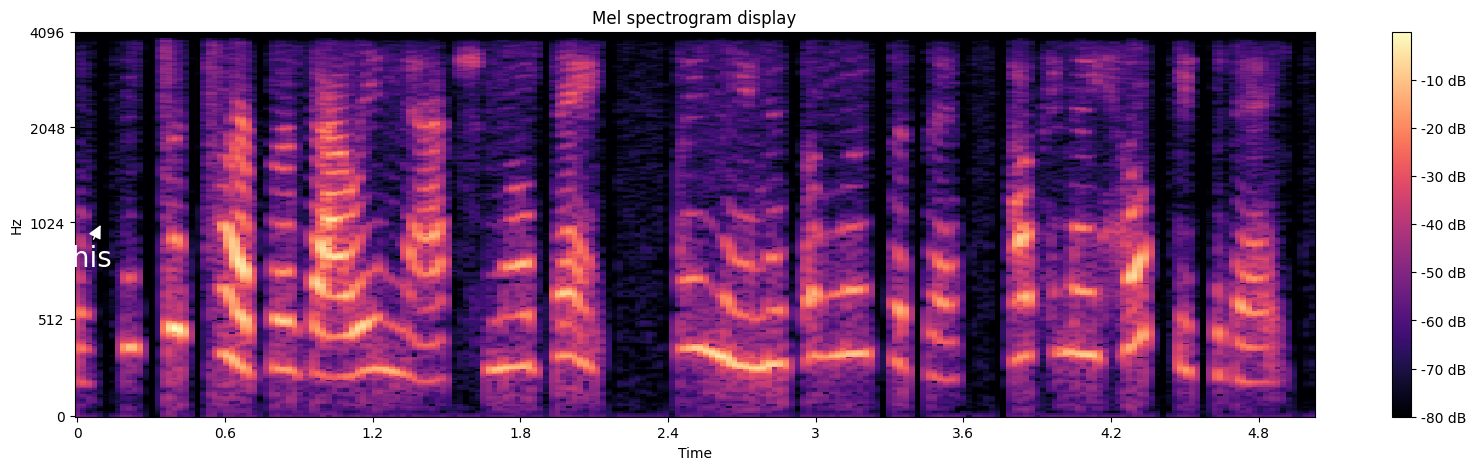

In [23]:
utt_words = [
    (0.1, 1024, "This"),
]
plot_melspectrogram(audio_signal, sr_agent, annotations=utt_words)

Your task is to label all remaining words in the utterance. Try to position each annotation at the center of each word in time (x axis). You may place the word anywhere along the frequency axis for readability. We won't check the time positions of your labels precisely, just point to each word without words overlapping when displayed.

Position text anywhere along the frequency (y) axis to avoid text overlap, there is no "correct" answer on where to position words along this axis, only the time axis.

In [24]:
# TODO: Position the remaining words correctly using the same format:
#  (time (s), frequency(Hz), annotation(string))
utt_words = [
    (0.1, 1024, "This"),
]
#############################
#### YOUR CODE GOES HERE ####
utt_words = [
    (0.1, 1024, "This"),
    (0.2, 768, "is"),
    (0.6, 1024, "Harper"),
    (1.0, 768, "Valley"),
    (1.4, 1024, "National"),
    (1.9, 768, "Bank"),
    (2.5, 1024, "My"),
    (2.7, 768, "name"),
    (2.8, 1024, "is"),
    (3.4, 768, "Elizabeth"),
    (3.9, 1024, "How"),
    (4.0, 768, "can"),
    (4.1, 1024, "I"),
    (4.3, 768, "help"),
    (4.5, 1024, "you"),
    (4.8, 768, "today"),
]

#############################

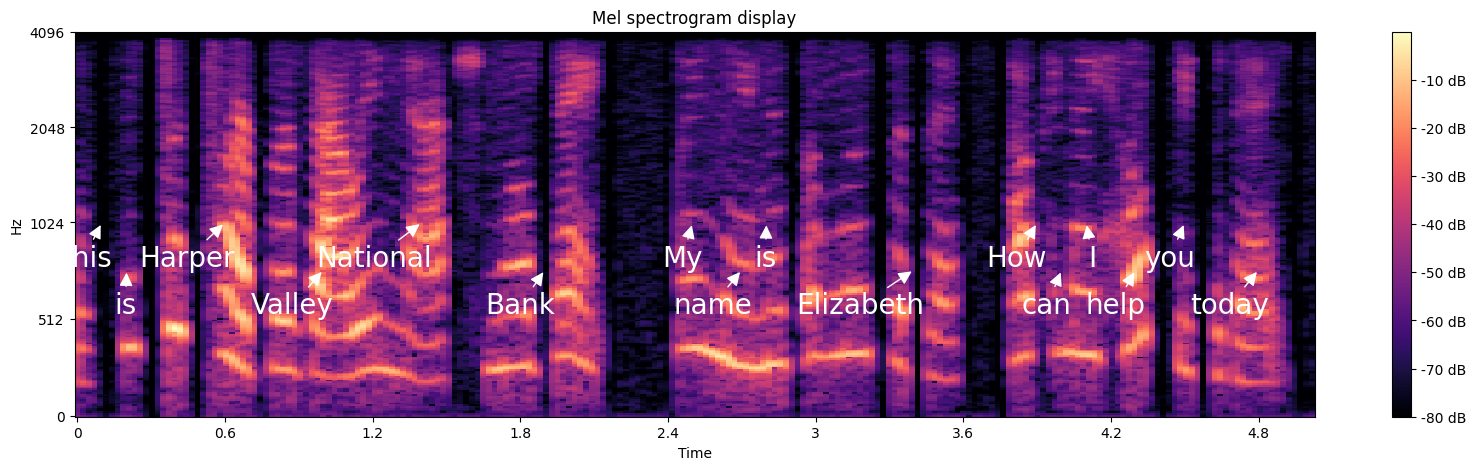

In [25]:
plot_melspectrogram(audio_signal, sr_agent, annotations=utt_words)

### **Task 5 (8 points): Visually estimate mean F_0**

F_0 is the fundamental frequency of a speaker (corresponding to the lowest harmonic of the speaker's glottal pulse train). On a Mel spectrogram, F_0 appears as the lowest frequency "line" of high energy in _voiced_ regions of speech (when the glottis is producing sound)

Visually estimate the mean F_0 frequency during the word national. Does the F_0 curve have high variance during this word? (it's okay if your F_0 estimate isn't exact.)

```
According to the Mel spectrogram above, the mean F_0 frequency of the word 'national' is ~200Hz. Compared to others words like 'bank', 'name' and 'Elizabeth', the varience during 'national' is moderate.
```

## IV. Visualizing alternative audio representations

We've been visualizing our utterances in Mel Spectrograms because it is easier to "read" speech-relevant phones in this view. Now let's look at the raw waveform time series plot itself. We will use the same `audio_signal` waveform in all the exercises below.

In [26]:
def show_waveplot(audio_signal, sr, annotations=None):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    # librosa.display.waveplot(audio_signal, sr=sr)
    librosa.display.waveshow(audio_signal, sr=sr)
    # iterate over list of text annotations and draw them
    if annotations is not None:
        for x, y, text in annotations:
            ax.annotate(
                text,
                xy=(x, y),
                xycoords="data",
                xytext=(10, -50),
                textcoords="offset pixels",
                horizontalalignment="right",
                color="black",
                fontsize=20,
                verticalalignment="bottom",
                arrowprops=dict(arrowstyle="-|>", color="black", lw=1, ls="-"),
            )

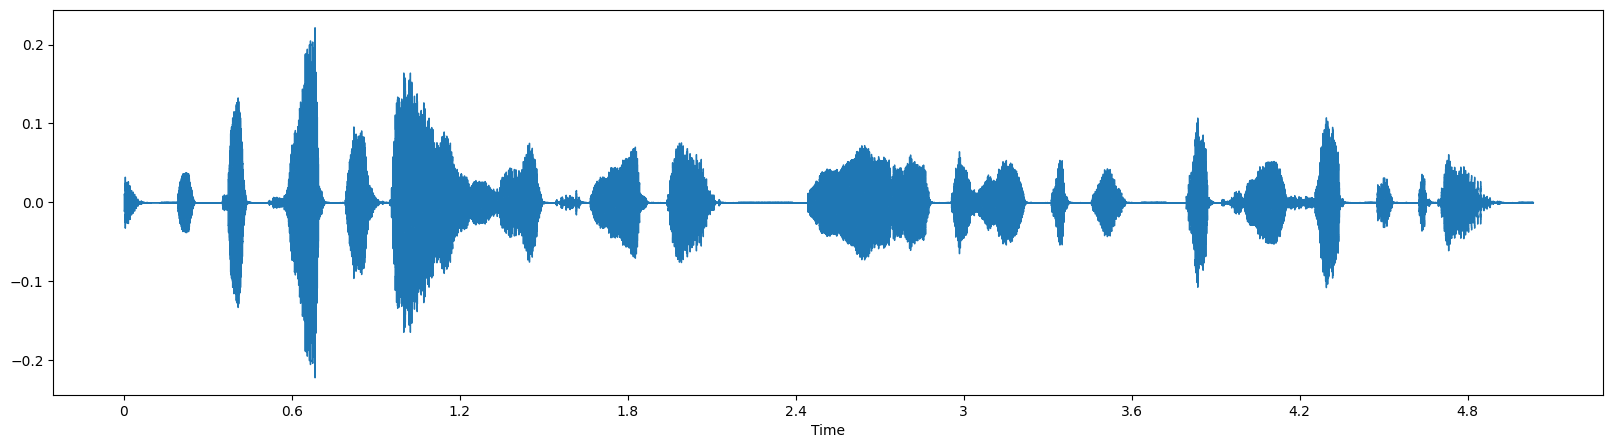

In [27]:
show_waveplot(audio_signal, sr_agent)

### **Problem 6 (8 points): Label words in the time domain plot** 

Populate word-level annotations for the time domain plot. You should be able to use the same time annotations from the spectrogram plot. However you will need to adjust the y axis positions for words (again precise positions on the vertical axis are not graded, just try to prevent overlapping words)

In [28]:
#  (time (s), amplitude, annotation(string))
utt_words = [
    (0.1, 0, "This"),
]
#############################
#### YOUR CODE GOES HERE ####
utt_words = [
    (0.1, 0, "This"),
    (0.2, 0.05, "is"),
    (0.6, 0, "Harper"),
    (1.0, 0.05, "Valley"),
    (1.4, 0, "National"),
    (1.9, 0.05, "Bank"),
    (2.5, 0, "My"),
    (2.7, 0.05, "name"),
    (2.8, 0, "is"),
    (3.4, 0.05, "Elizabeth"),
    (3.9, 0, "How"),
    (4.0, 0.05, "can"),
    (4.1, 0, "I"),
    (4.3, 0.05, "help"),
    (4.5, 0, "you"),
    (4.8, 0.05, "today"),
]

#############################

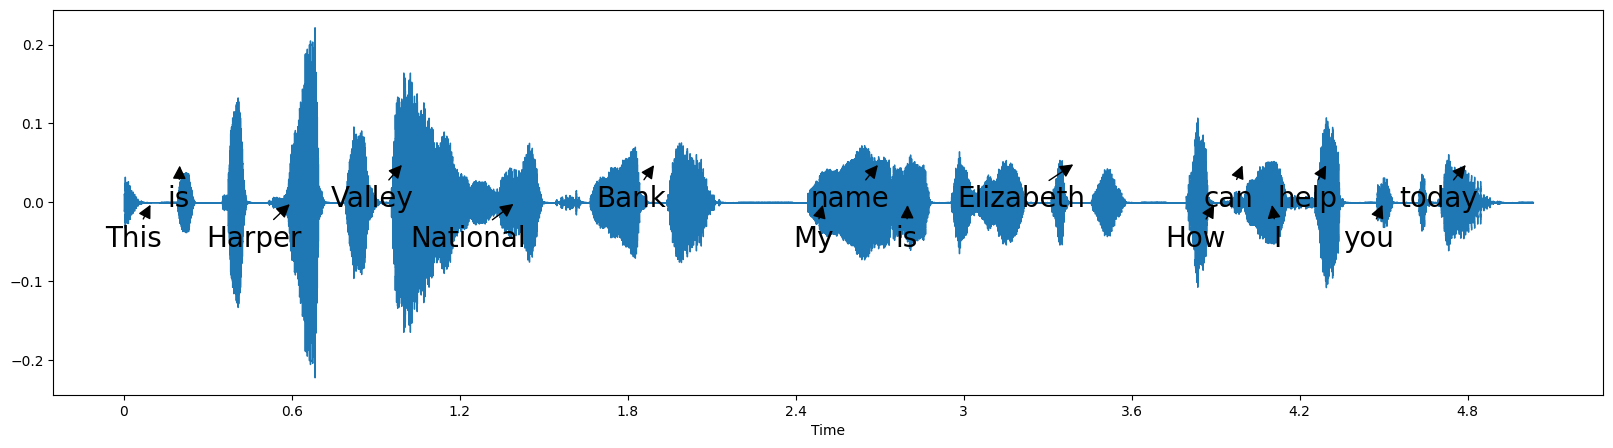

In [29]:
show_waveplot(audio_signal, sr_agent, utt_words)

Answer a few followup questions in text below:
1. Describe what aspects of speech you can infer in this time series plot compared to the Mel spectrum above. Compare the two, when might looking at one vs the other help when working with audio data?
2. Does each word have a distinct segment in the time-amplitude plot? (A segment in this context is portion of the waveform clearly larger than 0)
3. Specify a word that has more than one distinct segment in the time-amplitude plot.


```
1. The time series plot shows the amplitude of the audio signal over time, while the Mel spectrum show the frequency content of signal. 
When we need to analyze the exact timing of specific events or the overall shape of the waveform, it's better to look at the time series plot. 
When we need to recognize attributes of the speakers like gender or age, the Mel spectrogram is a better choice due to the frequency content of the signal.

2. Not each word have a distinct segment.

3. Elizabeth.
```